In [1]:
import numpy as np
np.random.seed(11)
import tensorflow as tf
tf.random.set_seed(11)

2023-02-12 08:41:09.291301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hanh/anaconda3/envs/flowers/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import keras.layers as layers
from keras.models import Sequential
from keras.utils import np_utils, load_img, img_to_array
from keras.callbacks import ModelCheckpoint

In [3]:
from sklearn.datasets import load_files
from tqdm import tqdm
import pandas as pd

## Load images

In [4]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 102)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('./Data/Datasplit/train')
valid_files, valid_targets = load_dataset('./Data/Datasplit/valid')
test_files, test_targets = load_dataset('./Data/Datasplit/test')

## Convert images to float

In [5]:
def path_to_tensor(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)      
    img = np.expand_dims(img, axis=0)  # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3)
    img = preprocess_input(img)
    return img

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████| 6149/6149 [00:26<00:00, 233.93it/s]


## Use Resnet50 weights

In [7]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#Loading the ResNet50 model with pre-trained ImageNet weights
resnet = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=inputs)

2023-02-12 08:41:49.956509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 08:41:49.957933: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
len(resnet.layers)

175

In [9]:
for layer in resnet.layers[:170]: layer.trainable = False

In [10]:
cnn = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(units=102, activation="softmax"),
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,804,902
Trainable params: 1,267,814
Non

In [11]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=True)

history = cnn.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

In [12]:
cnn.evaluate(train_tensors, train_targets)
cnn.evaluate(valid_tensors, valid_targets)
cnn.evaluate(test_tensors, test_targets);

193/193 [==============================] - 234s 1s/step - loss: 0.7983 - accuracy: 0.8037


In [13]:
cnn.save("./saved_models/cnn_resnet.h5")

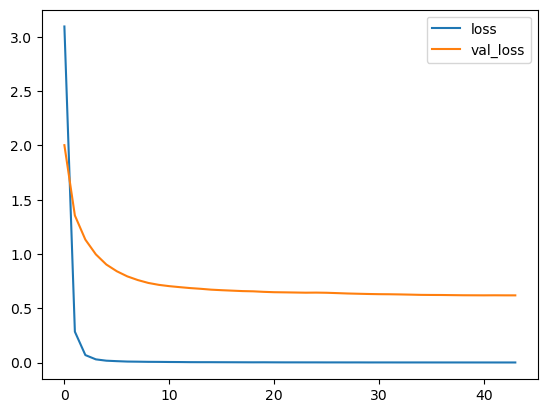

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

## Analyze the model predictions

In [15]:
# get prediction
flower_preds = [np.argmax(cnn.predict(np.expand_dims(tensor, axis=0), verbose=0)) for tensor in test_tensors]

In [24]:
# combine the model predictions against the actual labels
results = pd.DataFrame(list(zip(np.argmax(test_targets, axis=1), flower_preds)), columns =['Target', 'Pred'])
results['Accuracy'] = (results.Target==results.Pred)*1

In [25]:
results.head()

,Target,Pred,Accuracy
0,4,4,1
1,53,53,1
2,96,96,1
3,64,64,1
4,89,89,1


In [26]:
results.tail()

,Target,Pred,Accuracy
6144,84,84,1
6145,64,50,0
6146,40,40,1
6147,52,52,1
6148,54,54,1


In [89]:
results.describe()

,Target,Pred,Accuracy
count,6149.000000,6149.000000,6149.000000
mean,58.183444,56.408034,0.803708
std,27.539004,28.034007,0.397224
min,0.000000,0.000000,0.000000
25%,39.000000,36.000000,1.000000
50%,60.000000,59.000000,1.000000
75%,81.000000,80.000000,1.000000
max,101.000000,101.000000,1.000000


In [90]:
# Create accuracy rate for each category
summary = results.groupby(['Target'])['Accuracy'].agg(['mean', 'count']).\
        rename(columns={'mean':'Acc_rate', 'count':'Size'})
summary.describe()

,Acc_rate,Size
count,102.000000,102.000000
mean,0.820996,60.284314
std,0.162192,44.276891
min,0.300000,20.000000
25%,0.747845,29.000000
50%,0.855401,46.000000
75%,0.949569,72.750000
max,1.000000,238.000000


In [91]:
summary.reset_index(inplace=True)
summary.head()

,Target,Acc_rate,Size
0,0,0.700000,20
1,1,1.000000,25
2,2,0.896552,29
3,3,0.736842,38
4,4,0.928571,28


In [68]:
# there is no correlation between the accuracy and the number of images available
summary.corr()

,Acc_rate,Size
Acc_rate,1.000000,-0.146561
Size,-0.146561,1.000000


In [73]:
summary[summary['Acc_rate']<0.75].Size.count()

26

In [86]:
# Identify popular pair of wrong predictions
wrongs = results[results.Accuracy==0].groupby(['Target','Pred']).count()\
            .rename(columns={'Accuracy':'Size'}).reset_index()

In [87]:
wrongs.head()

,Target,Pred,Size
0,0,76,1
1,0,87,4
2,0,100,1
3,2,30,1
4,2,52,1


In [92]:
wrongs.sort_values(['Size'], ascending=False)

,Target,Pred,Size
267,49,72,18
568,89,78,14
270,49,84,13
268,49,76,12
256,49,26,12
...,...,...,...
273,49,91,1
274,49,95,1
275,49,96,1
276,49,97,1
